<a href="https://colab.research.google.com/github/eovallemagallanes/Digital-Image-Processing/blob/main/lecture01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LECTURE 1: Histograms and Contrast, Image Moments & Histogram Equalization

**IMPORT PACKAGES**

In [1]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, Checkbox

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku

**PLOT FUNCTION**

In [4]:
def show(img, show_hist=True, show_by_channel=False, density=False):
    dims = img.shape
    if len(dims) < 2:
        print('Not an image')
        return
    if len(dims) == 2:
        # gray scale image, require aditional last channel
        #print('Expandig last dim')
        img = np.expand_dims(img, -1)
    
    # map to uint8
    img = np.array(img, dtype = np.uint8) 

    channels = img.shape[-1] # last dim is the channel
    if channels == 3:
        labels = ['Red', 'Green', 'Blue']
        colors = ['r', 'g', 'b']
    else:
        labels = ['Gray']
        colors = ['gray']
    if show_hist:
        if show_by_channel and channels == 3:
            fig, axs = plt.subplots(2, channels + 1,
                                       figsize=(12, 6))
            
            # Display original image.
            axs[0, 0].imshow(img)
            axs[0, 0].set_axis_off()
            axs[1, 0].set_axis_off()
            for i in range(channels):
                axs[0, i+1].imshow(img[..., i])
                axs[0, i+1].set_axis_off()

            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[1, i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color, density=density)
                axs[1, i+1].set_xlim(0, img[..., i].max())
                axs[1, i+1].set(xlabel=label)
                axs[1, i+1].set_yticks([])
        
            plt.show()
        else:
            # Display the image.
            fig, axs = plt.subplots(1, channels + 1,
                                        figsize=(12, 3))
        
            if channels == 3:
                axs[0].imshow(img)
            if channels == 1:
                axs[0].imshow(img[..., 0], cmap='gray')
            axs[0].set_axis_off()
        
            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color, density=density)
              
        
            plt.show()
    else:
        # Display the image.
        fig = plt.figure(figsize=(3, 3))
        if channels == 3:
            plt.imshow(img)
        if channels == 1:
            plt.imshow(img[..., 0], cmap='gray')
        plt.axis('off')

**HISTOGRAM FUNCTION**

* Histograms plots how many times (frequency) each intensity value in image occurs, defined as

$h(x) = \# \{ (u, v) | I(u, v) = x \}, \forall x \in (0, 255),$

where $h(x)$ is the probability of the x-th gray level (random event) occurring .

* The Probability Distribution Function (pdf) of an image, is the probability that a intensity value chosen from the region is less than or equal to a given intensity value $x$, such that

$H(x) = \frac{1}{N} h(x),$

where $N$ is the total numbe rof pixels of the image.

* The Cumulative Distribution Function (cdf) or in this case, the cumulative histogram, is then defined as

$F(x) = \sum\limits_{x} H(x) = 1.$

***
$F(x)$ non decreasing
***



In [5]:
# raw implemantation for histogram & cumulative histogram
def histogram(img, normalize=False):
    img = np.array(img, dtype = np.uint8).ravel()
    H = img.shape[0]
    h = np.zeros((256))
    for i in range(H):
            pix = img[i]
            h[pix] += 1
    
    if normalize:
        h = h / H 
    return h



def cum_histogram(img, h_norm=None):
    if h_norm is None:
        h_norm = histogram(img, True)
    h_cum = np.ones((256))
    h_cum[0] = h_norm[0]
    for k in range(1,256):
        h_cum[k] = h_norm[k] + h_cum[k-1]

    return h_cum

**LOAD TEST IMAGE**

* Images are in uint8 by default: e.g., 8‐bit grayscale image have $ 2^8 = 256$ intensities values.
* Python skimage load images in a range of (0,1).

In [6]:
# working in range [0.0, 255.0]
img = skimage.img_as_float(skid.chelsea())*255.0
# read from file
#skimage.io.imread('address.jpeg') 

# convert to gray-scale image
gray_img = skic.rgb2gray(img)

**SHOW COLOR IMAGE**

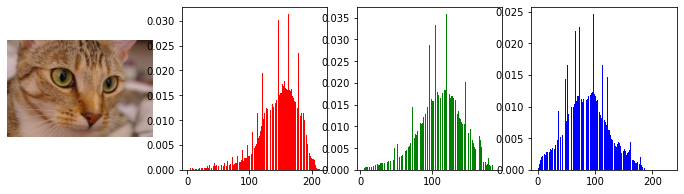

In [7]:
show(img, density=True)

**SHOW GRAYSCALE IMAGE**

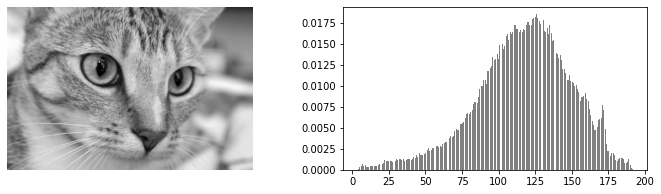

In [8]:
show(gray_img, density=True)

**IMAGE MOMENTS**

* The expected value of a random variable, e.g., the expected
value of random variable $x$ is obtained by letting
$g(x) = x$, such that

$\mu = E[x] = \sum\limits_{i=1}^{N} x_i H(x_i),$

where $x_i$ is the intensity value of the i-th pixel (the image is seen as a 1-D vector).

***
The mean is not a random variable, it is a fixed value for any PDF.
***

* The variance of a random variable, denoted by $\sigma^2$, is obtained by

$\sigma^2 = E[(x - \mu)^2] = E[x^2] - 2E[x \mu] + E[\mu^2] = E[x^2] - \mu^2 = E[x^2] - E[x]^2.$

***
Standard deviation is $\sigma$.

If a distribution has zero mean then: $E[x^2] = \sigma^2$
***



In [9]:
def expectedValue(img):
    h = histogram(img, True) # get normalized histogram (as pdf)
    e = 0
    for i in range(0, 256):
        e += i*h[i]

    # is the same:
    #n = np.arange(0, 256)
    #e = np.sum(n*h)
    return e


def variance(img):
    h = histogram(img, True) # get normalized histogam (as pdf)
    v = 0
    mu = expectedValue(img)
    for i in range(0, 256):
        v += (i**2*h[i])

    v = v - mu**2

    # is the same
    #n = np.arange(0, 256)
    #v = np.sum(n**2 *h) - mu**2

    return v

**COMPUTE THE EXPECTED VALUE AND VARIANCE OF AN IMAGE**

In [10]:
e = expectedValue(gray_img)
v = variance(gray_img)
e, v

(116.85726533628971, 1032.7473282200626)

In [11]:
np.mean(gray_img), np.var(gray_img)

(117.36603719660016, 1032.8586871925088)

**IMAGE CONTRAST**

* The contrast of a grayscale image indicates how easily objects in the image can be distinguished

* Michalson’s equation for contrast

$C_M(I) = \frac{max(I) - min(I)}{max(I) + min(I)}.$

In [12]:
def contrast(img):
    immax = np.max(img)
    immin = np.min(img)
    print('Max int: ', immax, 'Min int: ', immin)
    c = (immax - immin)/(immax + immin)
    return c

In [13]:
c = contrast(gray_img)
c

Max int:  192.6808 Min int:  3.8558000000000003


0.9607625246391768

**HISTOGRAM EQUALIZATION**

* Is a method of contrast adjustment using the image's histogram.
* The idea is to 'flat' the histogram 
* We would like to create a transformation of the form $y = T(x)$ to produce a new image $y$, with a flat histogram. 
* Such an image would have a linearized cumulative distribution function (CDF) across the value range, i.e.

$cdf_y(i)=iK,$

for some constant $K$. 

* The properties of the CDF allow us to perform such a transform (see Inverse distribution function); it is defined as

$y = T(k) = cdf_x(k),$

where $k$ is in the range [0,L]). 

* Notice that $T$ maps the levels into the range [0,1], since we used a normalized histogram of $x$.

* In order to map the values back into their original range, the following simple transformation needs to be applied on the result:

$y' = y\cdot (\max\{x\}-\min\{x\})+\min\{x\}$


In [14]:
def equalize(img, h_cum=None):
    if h_cum is None:
        h_cum = cum_histogram(img)
    img_max, img_min = np.max(img), np.min(img)

    img = np.array(img, dtype = np.uint8)
    H, W = img.shape
    img_eq = img.copy()
    for i in range(H):
        for j in range(W):
            pix = img[i, j] 
            prob = h_cum[pix]
            img_eq[i, j] = prob  * (img_max - img_min) + img_min
            #img_eq[i, j] = round(255. * prob)

    return img_eq


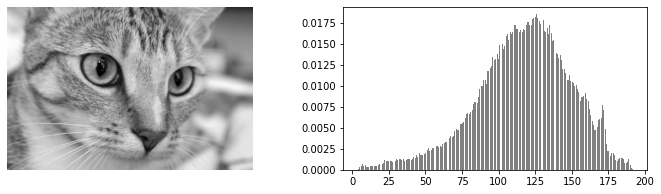

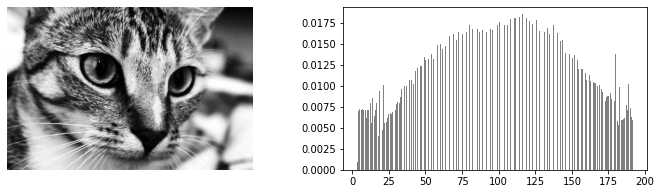

In [15]:
imgeq = equalize(gray_img)
show(gray_img, density=True)
show(imgeq, density=True)

In [16]:
c = contrast(imgeq)
c

Max int:  192 Min int:  3


0.9692308